# 1. Introduction

✅ Cardiovascular Disease dataset is a Kaggle Dataset (https://www.kaggle.com/sulianova/cardiovascular-disease-dataset) the containts history of health status of some persons. A group of them suffered a heart attackt. So using this dataset we can train a model in order to predict if a person could suffer a heart attack.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
from math import sqrt
from sklearn.metrics import r2_score

#import pandas_profiling

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

In [3]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [4]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

# 2. Exploratory Analysis

In [5]:
df = pd.read_csv('../Data/cardio_train.csv',sep=';')
df.shape

(70000, 13)

In [6]:
df.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1


In [7]:
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [8]:
## Pandas Profilling
#profile = df.profile_report(title="Pandas Profiling Report")
#profile.to_file('profile_report_cardio_disease.html')

In [9]:
df.cardio.value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

Data is balanced

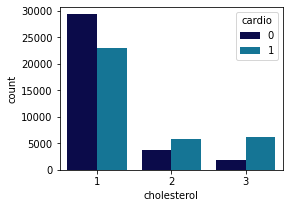

In [10]:
plt.figure(figsize=(4, 3))
sns.countplot(df.cholesterol,hue=df.cardio, palette= 'ocean')

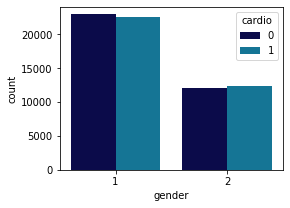

In [11]:
plt.figure(figsize=(4, 3))
sns.countplot(df.gender,hue=df.cardio, palette= 'ocean')

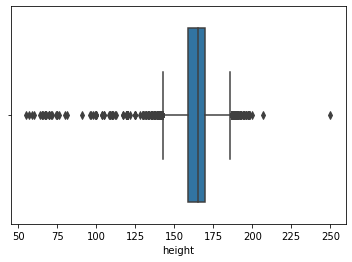

In [12]:
sns.boxplot(df.height)

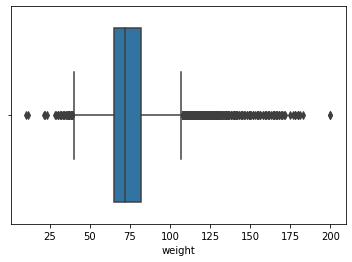

In [13]:
sns.boxplot(df.weight)

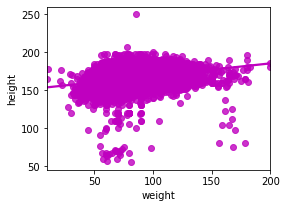

In [14]:
plt.figure(figsize=(4,3))
sns.regplot(df['weight'],df['height'],color='m')

# 3. Feature Engineering

## 3.1 Outliers

In [15]:
df = df[(df['height']<250) & (df['weight']>20.0)]
df.shape

(69997, 13)

In [16]:
df["bmi"] = (df["weight"]/ (df["height"]/100)**2).round(1)

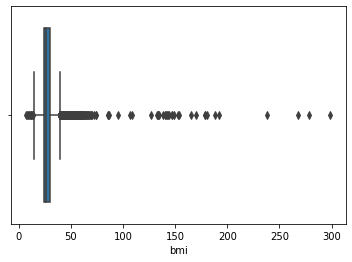

In [17]:
sns.boxplot(df.bmi)

In [18]:
df[(df['bmi']>10) & (df['bmi']<100)].shape

(69964, 14)

In [19]:
df = df[(df['bmi']>10) & (df['bmi']<100)]
df.shape

(69964, 14)

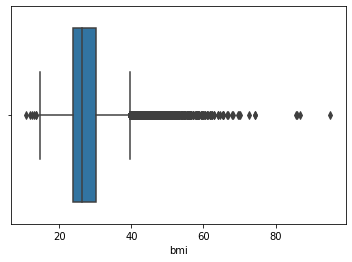

In [20]:
sns.boxplot(df.bmi)

In [21]:
df.age = np.round(df.age/365.25,decimals=1)

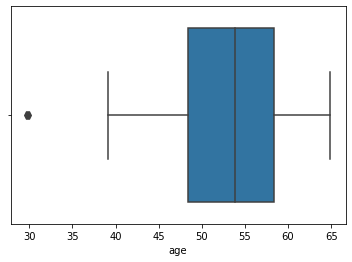

In [22]:
sns.boxplot(df.age)

In [23]:
df= df[(df['ap_lo']<360) & (df['ap_hi']<360)].copy()
df= df[(df['ap_lo']>20) & (df['ap_hi']>20)].copy()
df=df[df['ap_hi']>df['ap_lo']]
df.shape

(68645, 14)

In [24]:
df['cholesterol']=df['cholesterol'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc']=df['gluc'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gender']=df['gender'].map({ 1: 'M', 2: 'F'})
df['smoke']=df['smoke'].map({ 0: 'No', 1: 'Yes'})
df['alco']=df['alco'].map({ 0: 'No', 1: 'Yes'})
df['active']=df['active'].map({ 0: 'No', 1: 'Yes'})
df.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50.4,F,168,62.0,110,80,normal,normal,No,No,Yes,0,22.0
1,1,55.4,M,156,85.0,140,90,well above normal,normal,No,No,Yes,1,34.9


In [25]:
df_numerical_data = df[['age','height','weight','ap_hi','ap_lo','bmi','cardio']]

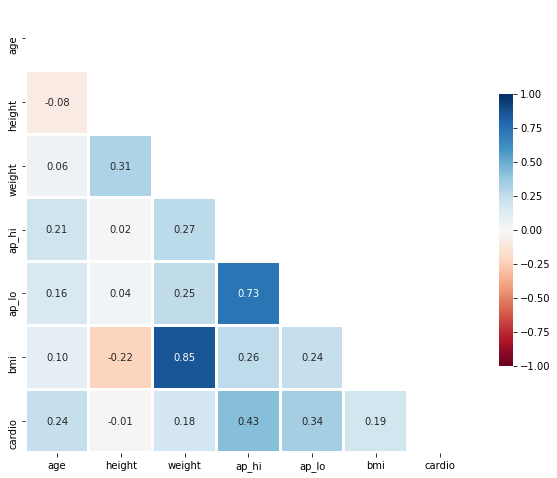

In [26]:
corr=df_numerical_data.corr(method='pearson')
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
palette = sns.diverging_palette(50, 200, n=256)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu', mask= mask, vmin=-1, vmax=1, center= 0,
            square=True, linewidths=2, cbar_kws={"shrink": .5})

In [27]:
#If any correlation higher than 90%
corr_mask_numerical = corr.mask(mask)
corr_values_numerical = [c for c in corr_mask_numerical.columns if any (corr_mask_numerical[c] > 0.90)]
print(corr_values_numerical)

[]


In [28]:
##Finding skew data
df_numerical_data = df_numerical_data.drop(['cardio'], axis=1)
skew_features = df_numerical_data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]

In [29]:
skewness = pd.DataFrame({'Skew' :skew_features})
skewness

,Skew
bmi,1.377260
weight,0.988405
ap_hi,0.933976
ap_lo,0.359565
height,-0.114360
age,-0.306133


In [30]:
high_skew

bmi       1.377260
weight    0.988405
ap_hi     0.933976
dtype: float64

In [31]:
# boxcox_normmax = Compute optimal Box-Cox transform parameter for input data.
for features in high_skew.index:
    df[features]= boxcox1p(df[features],  boxcox_normmax(df[features] + 1))

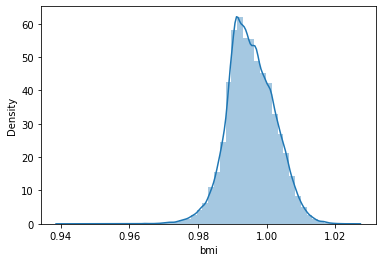

In [32]:
sns.distplot(df.bmi)

### Encoding

In [33]:
df.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50.4,F,168,2.154936,1.499670,80,normal,normal,No,No,Yes,0,0.987265
1,1,55.4,M,156,2.221375,1.510934,90,well above normal,normal,No,No,Yes,1,1.004914


In [34]:
df.dtypes

id               int64
age            float64
gender          object
height           int64
weight         float64
ap_hi          float64
ap_lo            int64
cholesterol     object
gluc            object
smoke           object
alco            object
active          object
cardio           int64
bmi            float64
dtype: object

#### One-hot encoding

In [35]:
#One hot encoding
def one_hot_encoding(dataset, feature):
    dummy_dataset = pd.get_dummies(dataset[[feature]])
    encode_dataset = pd.concat([dataset, dummy_dataset], axis=1)
    encode_dataset = encode_dataset.drop([feature], axis=1)
    return(encode_dataset)

In [36]:
encoding_features = ['gender','cholesterol','gluc','smoke','alco','active']
for feature in encoding_features:
    df = one_hot_encoding(df, feature)
df.shape

(68645, 22)

In [37]:
df.head(2)

,id,age,height,weight,ap_hi,ap_lo,cardio,bmi,gender_F,gender_M,cholesterol_above normal,cholesterol_normal,cholesterol_well above normal,gluc_above normal,gluc_normal,gluc_well above normal,smoke_No,smoke_Yes,alco_No,alco_Yes,active_No,active_Yes
0,0,50.4,168,2.154936,1.499670,80,0,0.987265,1,0,0,1,0,0,1,0,1,0,1,0,0,1
1,1,55.4,156,2.221375,1.510934,90,1,1.004914,0,1,0,0,1,0,1,0,1,0,1,0,0,1


### Standarazition

In [38]:
df_numerical_data.columns

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi'], dtype='object')

In [39]:
df = df.drop(['id'], axis=1)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio',axis=1),df.cardio,test_size=0.30, random_state=42)

In [41]:
to_be_scaled_feat = ['age','height','weight', 'ap_hi', 'ap_lo','bmi']
other_feat = ['gender_F', 'gender_M', 'cholesterol_above normal',
       'cholesterol_normal', 'cholesterol_well above normal',
       'gluc_above normal', 'gluc_normal', 'gluc_well above normal',
       'smoke_No', 'smoke_Yes', 'alco_No', 'alco_Yes', 'active_No',
       'active_Yes']

In [42]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

scaler.fit(X_train[to_be_scaled_feat])

X_train[to_be_scaled_feat] = scaler.transform(X_train[to_be_scaled_feat])
X_test[to_be_scaled_feat] = scaler.transform(X_test[to_be_scaled_feat])

In [43]:
X_train.head(2)

,age,height,weight,ap_hi,ap_lo,bmi,gender_F,gender_M,cholesterol_above normal,cholesterol_normal,cholesterol_well above normal,gluc_above normal,gluc_normal,gluc_well above normal,smoke_No,smoke_Yes,alco_No,alco_Yes,active_No,active_Yes
532,-1.107522,0.576735,0.044188,-0.327016,-0.134423,-0.231948,0,1,0,1,0,0,1,0,1,0,1,0,1,0
16830,-0.411979,2.203742,1.702748,0.311608,-0.134423,0.734300,1,0,0,1,0,0,1,0,1,0,1,0,0,1


# 4. Azure ML Workspace Configuration

In [44]:
from azureml.core import Workspace
ws = Workspace.from_config()

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (portalocker 2.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('portalocker~=1.0'), {'msal-extensions'}).


In [45]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name="cardiovascular-experiment")

In [46]:
"""
for i in experiment.get_runs():
    i.complete()
experiment.archive()
"""

'\nfor i in experiment.get_runs():\n    i.complete()\nexperiment.archive()\n'

# 5. Model Building

In [47]:
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [48]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "XGB")

model_xgb= XGBClassifier(colsample_bytree = 0.3,
                        learning_rate = 0.03,
                        max_depth = 5,
                        min_child_weight = 5, 
                        n_estimators = 500,
                        objective ='binary:logistic',
                        metric = 'auc')

model_xgb.fit(X_train, y_train)
#y_pred_xgbm = model_xgb.predict(X_test)
y_pred_xgbm = model_xgb.predict_proba(X_test)[:, 1]
print('XGBM– ' + str(roc_auc_score(y_test, y_pred_xgbm)))
run.log("AUC", roc_auc_score(y_test, y_pred_xgbm))

model_name = "model_xgb.pkl"
filename = "outputs/" + model_name
joblib.dump(value=model_xgb, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

XGBM– 0.7997297166479319


In [49]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "LightGBM")

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'AUC' },
    'num_leaves': 32,#50
    'max_depth': 3,#3
    'min_data_in_leaf': 30,#4000
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'verbose': 1,
    'is_unbalance':True,
    'learning_rate': 0.005,#0.01
    'bagging_fraction': 0.9,
}

train_set = lgb.Dataset(X_train, y_train)
validation_sets = lgb.Dataset(X_test, y_test, reference=train_set)

model_lgbm = lgb.train(
    params,
    train_set,
    num_boost_round=10000,
    valid_sets=validation_sets,
    early_stopping_rounds=500,
    verbose_eval=False
    )

y_pred_lgbm = model_lgbm.predict(X_test)
print('LGBM– ' + str(roc_auc_score(y_test, y_pred_lgbm)))
run.log("AUC", roc_auc_score(y_test, y_pred_lgbm))

model_name = "model_lgbm.pkl"
filename = "outputs/" + model_name
joblib.dump(value=model_lgbm, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

LGBM– 0.7998037353567831


In [50]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "GradientBoosting")

model_gbr= GradientBoostingClassifier(learning_rate=0.01, 
                                     max_depth=6, 
                                     max_features=0.1,
                                     min_samples_leaf=30, 
                                     n_estimators=1000)
model_gbr.fit(X_train, y_train)
#y_pred_gbr = model_gbr.predict(X_test)
y_pred_gbr = model_gbr.predict_proba(X_test)[:, 1]
print('GBR– ' + str(roc_auc_score(y_test, y_pred_gbr)))
run.log("AUC", roc_auc_score(y_test, y_pred_gbr))

model_name = "model_gbr.pkl"
filename = "outputs/" + model_name
joblib.dump(value=model_gbr, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

GBR– 0.7997802602591364


In [51]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "LogisticRegression")

model_log = LogisticRegression()
model_log.fit(X_train, y_train)
#y_pred_log = model_log.predict(X_test)
y_pred_log = model_log.predict_proba(X_test)[:, 1]
print('LogReg– ' + str(roc_auc_score(y_test, y_pred_log)))
run.log("AUC", roc_auc_score(y_test, y_pred_log))

model_name = "model_log.pkl"
filename = "outputs/" + model_name
joblib.dump(value=model_log, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

LogReg– 0.785985542131585


In [52]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "DecisionTree")

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
#y_pred_dt = model_dt.predict(X_test)
y_pred_dt = model_dt.predict_proba(X_test)[:, 1]
print('DecTree– ' + str(roc_auc_score(y_test, y_pred_dt)))
run.log("AUC", roc_auc_score(y_test, y_pred_dt))

model_name = "model_dt.pkl"
filename = "outputs/" + model_name
joblib.dump(value=model_dt, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

DecTree– 0.6296967360692037


In [53]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "Random Forest")

param_grid = {'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]}
model_rf = GridSearchCV(RandomForestClassifier(),param_grid,verbose=0,n_jobs=-1)
model_rf.fit(X_train,y_train)
best_parameters = model_rf.best_params_
print(best_parameters)
#y_pred_rf = model_rf.predict(X_test)
y_pred_rf = model_rf.predict_proba(X_test)[:, 1]
print('RandomForest– ' + str(roc_auc_score(y_test, y_pred_rf)))
run.log("AUC", roc_auc_score(y_test, y_pred_rf))

model_name = "model_rf.pkl"
filename = "outputs/" + model_name
joblib.dump(value=model_rf, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

{'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RandomForest– 0.7939900929994901


In [54]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "SVC")

model_svc = SVC(probability=True)
model_svc.fit(X_train, y_train)
#y_pred_svc = model_svc.predict(X_test)
y_pred_svc = model_svc.predict_proba(X_test)[:, 1]
print('SVC– ' + str(roc_auc_score(y_test, y_pred_svc)))
run.log("AUC", roc_auc_score(y_test, y_pred_svc))

model_name = "model_svc.pkl"
filename = "outputs/" + model_name
joblib.dump(value=model_svc, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

SVC– 0.7893707757085235


In [55]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "Stacking")

stack = StackingCVClassifier(classifiers=(model_xgb, model_gbr,model_log, model_rf,model_svc),
                            meta_classifier=model_xgb, use_features_in_secondary=True,n_jobs=-1)
stack_model = stack.fit(X_train.values, y_train.values)
print('STACK MODEL– ' + str(roc_auc_score(y_test, stack_model.predict_proba(X_test.values)[:, 1])))
run.log("AUC", roc_auc_score(y_test, stack_model.predict_proba(X_test.values)[:, 1]))

model_name = "stack_model.pkl"
filename = "outputs/" + model_name
joblib.dump(value=stack_model, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

STACK MODEL– 0.7998259560598988


In [56]:
run = experiment.start_logging(snapshot_directory=None)
run.log("model_type", "Mixing Models")

def mixing_models_predict(X): return ((0.05 * model_xgb.predict_proba(X)[:, 1]) + 
                                     (0.5 * model_lgbm.predict(X)) + 
                                     (0.05 * model_gbr.predict_proba(X)[:, 1]) +  
                                     (0.05 * model_log.predict_proba(X)[:, 1]) + 
                                     #(0.1 * model_dt.predict_proba(X)[:, 1]) +
                                     (0.05 * model_rf.predict_proba(X)[:, 1]) +
                                     (0.05 * model_svc.predict_proba(X)[:, 1]) +
                                     (0.25 * stack_model.predict_proba(X.values)[:, 1]))
y_pred_mix = mixing_models_predict(X_test)
print('Mixed MODEL– ' + str(roc_auc_score(y_test, y_pred_mix)))
run.log("AUC", roc_auc_score(y_test, y_pred_mix))

#model_name = "stack_model.pkl"
#filename = "outputs/" + model_name
#joblib.dump(value=stack_model, filename=filename)
#run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

Mixed MODEL– 0.8001945311265648


In [57]:
print("AUC")
print('XGB– ' + str(roc_auc_score(y_test, y_pred_xgbm)))
print('LGBM– ' + str(roc_auc_score(y_test, y_pred_lgbm)))
print('GBR– ' + str(roc_auc_score(y_test, y_pred_gbr)))
print('LogReg– ' + str(roc_auc_score(y_test, y_pred_log)))
print('DecTree– ' + str(roc_auc_score(y_test, y_pred_dt)))
print('RandomForest– ' + str(roc_auc_score(y_test, y_pred_rf)))
print('SVC– ' + str(roc_auc_score(y_test, y_pred_svc)))
print('STACK MODEL– ' + str(roc_auc_score(y_test, stack_model.predict_proba(X_test.values)[:, 1])))
print('Mixed MODEL– ' + str(roc_auc_score(y_test, y_pred_mix)))

AUC
XGB– 0.7997297166479319
LGBM– 0.7998037353567831
GBR– 0.7997802602591364
LogReg– 0.785985542131585
DecTree– 0.6296967360692037
RandomForest– 0.7939900929994901
SVC– 0.7893707757085235
STACK MODEL– 0.7998259560598988
Mixed MODEL– 0.8001945311265648


We can see the Mixed Model is the model with the highest  AUC

In [58]:
def mixing_models_predict_int(X): return (((0.05 * model_xgb.predict(X)) + 
                                     (0.5 * (model_lgbm.predict(X) >= 0.5)*1.0) + 
                                     (0.05 * model_gbr.predict(X)) +  
                                     (0.05 * model_log.predict(X)) + 
                                     #(0.1 * model_dt.predict(X)) +
                                     (0.05 * model_rf.predict(X)) +
                                     (0.05 * model_svc.predict(X)) +
                                     (0.25 * stack_model.predict(X.values)))>= 0.5)*1.0
y_pred_mix_int = mixing_models_predict_int(X_test)

In [59]:
print("ACCURACY")
print('XGBM– ' + str(accuracy_score(y_test, model_xgb.predict(X_test))))
print('LGBM– ' + str(accuracy_score(y_test, (model_lgbm.predict(X_test) >= 0.5)*1.0)))
print('GBR– ' + str(accuracy_score(y_test, model_gbr.predict(X_test))))
print('LogReg– ' + str(accuracy_score(y_test, model_log.predict(X_test))))
print('DecTree– ' + str(accuracy_score(y_test, model_dt.predict(X_test))))
print('RandomForest– ' + str(accuracy_score(y_test, model_rf.predict(X_test))))
print('SVC– ' + str(accuracy_score(y_test, model_svc.predict(X_test))))
print('STACK MODEL– ' + str(accuracy_score(y_test, stack_model.predict(X_test.values))))
print('Mixed MODEL– ' + str(accuracy_score(y_test, y_pred_mix_int)))

ACCURACY
XGBM– 0.7327376905894921
LGBM– 0.7330290375837623
GBR– 0.7315723026124114
LogReg– 0.7247256482470622
DecTree– 0.6296008546178499
RandomForest– 0.7275420025250073
SVC– 0.7290958531611149
STACK MODEL– 0.7335631737399243
Mixed MODEL– 0.7327862484218705


We can see the LightGBM Model is the model with the highest Accuracy

✅ We can choose the LightGBM for production because is less complex in comparison of the Mixed Model

In [60]:
from sklearn.metrics import (recall_score, accuracy_score, precision_score, auc, roc_curve, f1_score)
def filter_threshold(probabilities, threshold):
    return [1 if f >= threshold else 0 for f in probabilities]

def get_threshold_measures_df(observed, probabilities, steps=0.05):
    if isinstance(steps, float):
        steps = np.arange(0, 1, steps)
    df = pd.DataFrame(columns=['Punto de corte', 'N_Predicted', 'Recall', 'Accuracy', 'Precision','F1 score'])

    for i in range(len(steps)):
        estimated_threshold = filter_threshold(probabilities, steps[i])
        row = [
            steps[i],
            sum(estimated_threshold),
            recall_score(observed, estimated_threshold),
            accuracy_score(observed, estimated_threshold),
            precision_score(observed, estimated_threshold),
            f1_score(observed, estimated_threshold),
        ]
        df.loc[i] = row

    return df

In [61]:
get_threshold_measures_df(y_test, y_pred_lgbm)

,Punto de corte,N_Predicted,Recall,Accuracy,Precision,F1 score
0,0.00,20594.0,1.000000,0.498495,0.498495,0.665327
1,0.05,20526.0,0.999805,0.501602,0.500049,0.666667
2,0.10,20006.0,0.995909,0.522968,0.511047,0.675476
3,0.15,19010.0,0.985681,0.561134,0.532299,0.691283
4,0.20,17800.0,0.966004,0.600272,0.557135,0.706691
5,0.25,16192.0,0.930158,0.642614,0.589736,0.721823
6,0.30,14477.0,0.884083,0.679955,0.626925,0.733622
7,0.35,12987.0,0.837327,0.705691,0.661893,0.739345
8,0.40,11449.0,0.780148,0.723366,0.699537,0.737647
9,0.45,10261.0,0.730470,0.731524,0.730825,0.730647


# 6. Register Model

In [63]:
from azureml.core.model import Model

In [64]:
# register the model for deployment
model = Model.register(model_path = "outputs/model_lgbm.pkl", # this points to a local file
                       model_name = "cardiovascular_disease_predictor", # name the model is registered as
                       tags = {'area': "Health", 'type': "classification"}, 
                       description = "Classification Model that predicts if a person could suffer a heart attack", 
                       workspace = ws)

print()
print("Model registered: {} \nModel Description: {} \nModel Version: {}".format(model.name, 
                                                                                model.description, model.version))

Registering model cardiovascular_disease_predictor

Model registered: cardiovascular_disease_predictor 
Model Description: Classification Model that predicts if a person could suffer a heart attack 
Model Version: 1


# 7. Conclussions

Data required in order to predict if a person could suffer a heart attack:
    [age, gender, heigth, weight, blood pressure, cholesterol, gluosa, smole]

✅ In many regions with a high poverty rate there are hospitals with basic equipment. Sick people come to be treated for very common illnesses such as heart attacks, but many times doctors cannot help them due to lack of equipment. Thus this solution can help doctors to predict in time whether a person is prone to suffer an attack and thus give them timely treatment. Hope this solution can motivate to other people to use Machine Learning on Health.